## Non-linear

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.random import multivariate_normal as mvn

In [2]:
N = 100
dt = 0.1
q1, q2 = 1, 1
s1, s2 = 0.5, 0.5

Q = np.array([[(q1 * dt**3) / 3, 0, (q1 * dt**2) / 2, 0],
              [ 0, (q2 * dt**3) / 3, 0, (q2 * dt**2) / 2],
              [(q1 * dt**2) / 2, 0, q1 * dt, 0],
              [0, (q2 * dt**2) / 2, 0, q2 * dt]])

R = np.array([[s1, 0],
              [0, s2]])

A = np.array([[1, 0, dt, 0],
             [0, 1, 0, dt],
             [0, 0, 1, 0],
             [0, 0, 0, 1]])

H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

# Nonlinear state transition function
def f(x):
    return np.array([0.1 * np.sin(x[0]), 0.1 * np.sin(x[1]), 0, 0])

def f_full(x):
    return A @ x + f(x)

# Nonlinear observation function
def h(x):
    return np.array([0.5 * np.sin(x[1]), -0.5 * np.cos(x[0])])

def h_full(x):
    return H @ x + h(x)    

# Jacobians of the state transition and observation functions
def F_jacobian(x):
    return np.array([[1, 0, dt, 0],
                     [0, 1, 0, dt],
                     [0.1 * np.cos(x[0]), 0, 1, 0],
                     [0, 0.1 * np.cos(x[1]), 0, 1]])

def H_jacobian(x):
    return np.array([[1, 1.5 * np.cos(x[1]), 0, 0],
                     [1.5 * np.sin(x[0]), 1, 0, 0]])

# Generate data with nonlinear true path and nonlinear observations
x = np.array([0, 0, 1, 1])
true_trajectory = [x]
noisy_observations = [h_full(x)]

for _ in range(N):
    x = f_full(x) + mvn([0, 0, 0, 0], Q)
    y = h_full(x) + mvn([0, 0], R)

    true_trajectory.append(x)
    noisy_observations.append(y)

true_trajectory = np.array(true_trajectory)
noisy_observations = np.array(noisy_observations)

In [ ]:
P = np.eye(4)
m = true_trajectory[0]
estimated_trajectory_KF = [m]
Ps = [P]

for y in noisy_observations:
    m_pred = A @ m
    P_pred = A @ P @ A.T + Q
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    m = m_pred + K @ (y - H @ m_pred)
    P = P_pred - K @ S @ K.T
    
    Ps.append(P)
    estimated_trajectory_KF.append(m)

Ps = np.array(Ps)
estimated_trajectory_KF = np.array(estimated_trajectory_KF)

In [3]:
# Kalman filter

P = np.eye(4)
m = true_trajectory[0]
estimated_trajectory_KF = [m]
Ps = [P]

for y in noisy_observations:
    m_pred = A @ m
    P_pred = A @ P @ A.T + Q
    
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    m = m_pred + K @ (y - H @ m_pred)
    P = P_pred - K @ S @ K.T
    
    Ps.append(P)
    estimated_trajectory_KF.append(m)

Ps = np.array(Ps)
estimated_trajectory_KF = np.array(estimated_trajectory_KF)

In [4]:
# RTS smoother
n, dim_x = estimated_trajectory_KF.shape

estimated_trajectory_RTS, P = estimated_trajectory_KF.copy(), Ps.copy()

for k in range(n-2,-1,-1):
    P_pred = A @ P[k] @ A.T + Q

    G = P[k] @ A.T @ np.linalg.inv(P_pred)
    estimated_trajectory_RTS[k] += G @ (estimated_trajectory_RTS[k+1] - A @ estimated_trajectory_RTS[k])
    #P[k] += (G @ (P[k+1] - P_pred)) @ G.T

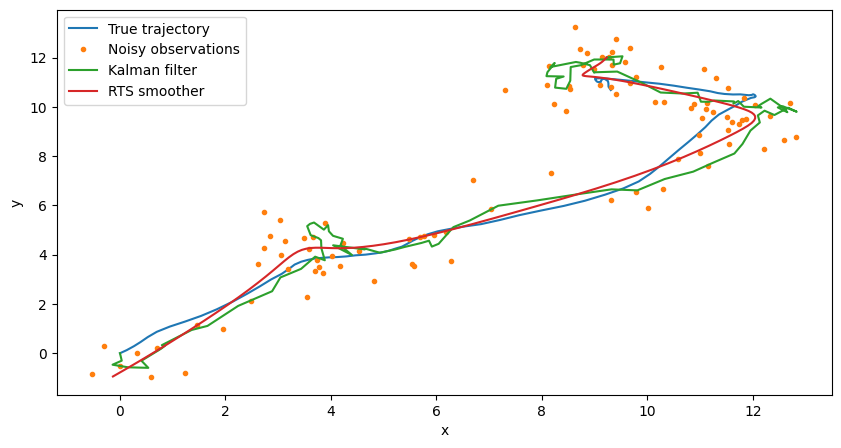

In [5]:
# Plot the results
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(true_trajectory[:, 0], true_trajectory[:, 1], label="True trajectory")
ax.plot(noisy_observations[:, 0], noisy_observations[:, 1], '.', label="Noisy observations")
plt.plot(estimated_trajectory_KF[:, 0], estimated_trajectory_KF[:, 1], label="Kalman filter")
ax.plot(estimated_trajectory_RTS[:, 0], estimated_trajectory_RTS[:, 1], label="RTS smoother")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
plt.show()

In [11]:
# EKF with nonlinear true path and nonlinear observations
P = np.eye(4)
m = true_trajectory[0]
estimated_trajectory_EKF = [m]
Ps = [P]

for y in noisy_observations:
    F = F_jacobian(m)
    m_pred = f(m)
    P_pred = F @ P @ F.T + Q
    
    H = H_jacobian(m_pred)
    
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    m = m_pred + K @ (y - h_full(m_pred))
    P = P_pred - K @ S @ K.T
        
    Ps.append(P)
    estimated_trajectory_EKF.append(m)

Ps = np.array(Ps)
estimated_trajectory_EKF = np.array(estimated_trajectory_EKF)

In [12]:
from scipy.linalg import sqrtm

def sigma_points(mean, covariance, kappa):
    n = len(mean)
    U = sqrtm((n + kappa) * covariance)
    return np.column_stack((mean, mean + U, mean - U))

def unscented_transform(sigmas, Wm, Wc, noise_cov=None):
    mean = np.dot(sigmas, Wm)  # Updated this line
    residual = sigmas - mean.reshape(-1, 1)
    covariance = np.dot(residual * Wc, residual.T)
    if noise_cov is not None:
        covariance += noise_cov
    return mean, covariance

def ukf_step(m, P, y, f, Q, h_true, R, kappa=None):
    n = len(m)
    if kappa is None:
        kappa = 1e-3  # Updated this line #3 - n  # Updated this line
    
    # Generate sigma points
    sigmas = sigma_points(m, P, kappa)

    # Predict step
    sigmas_pred = np.apply_along_axis(f, 0, sigmas)
    Wm = np.full(2 * n + 1, 1 / (2 * (n + kappa)))  # Updated this line
    Wm[0] = kappa / (n + kappa)
    Wc = np.copy(Wm)
    Wc[0] = Wc[0] + (1 - kappa**2)
    m_pred, P_pred = unscented_transform(sigmas_pred, Wm, Wc, Q)

    # Update step
    sigmas_pred_obs = np.apply_along_axis(h_true, 0, sigmas_pred)
    y_pred, P_yy = unscented_transform(sigmas_pred_obs, Wm, Wc, R)
    P_xy = np.dot((sigmas_pred - m_pred.reshape(-1, 1)) * Wc, (sigmas_pred_obs - y_pred.reshape(-1, 1)).T)
    K = P_xy @ np.linalg.inv(P_yy)
    m_new = m_pred + K @ (y - y_pred)
    P_new = P_pred - K @ P_yy @ K.T
    
    return m_new, P_new

# UKF with nonlinear true path and nonlinear observations
P = np.eye(4)
m = true_trajectory[0]
estimated_trajectory_UKF = [m]
Ps = [P]

for y in noisy_observations:
    m, P = ukf_step(m, P, y, f, Q, h_full, R)  # Removed the kappa argument
    Ps.append(P)
    estimated_trajectory_UKF.append(m)

Ps = np.array(Ps)
estimated_trajectory_UKF = np.array(estimated_trajectory_UKF)

In [13]:
from pykalman import UnscentedKalmanFilter

def f_linear(x):
    return A @ x

def h_linear(x):
    return H @ x

def f_full_with_noise(x, noise):
    return f_full(x) + noise

def h_full_with_noise(x, noise):
    return h_full(x) + noise

# Initialize the Unscented Kalman Filter
ukf = UnscentedKalmanFilter(initial_state_mean = true_trajectory[0],
                            initial_state_covariance = np.eye(4),
                            transition_functions = (f_full_with_noise, f_linear),
                            observation_functions = (h_full_with_noise, h_linear),
                            transition_covariance = Q,
                            observation_covariance = R)

# Apply the UKF to the noisy observations
estimated_trajectory_UKF_builtin, Ps = ukf.smooth(noisy_observations)

# Convert the results to numpy arrays
estimated_trajectory_UKF_builtin = np.array(estimated_trajectory_UKF_builtin)
Ps = np.array(Ps)

In [14]:
# Implement the EKF with nonlinear true path and nonlinear observations
from filterpy.kalman import ExtendedKalmanFilter

# Define the EKF object
ekf = ExtendedKalmanFilter(dim_x=4, dim_z=2)

# Define the EKF functions
ekf.x = true_trajectory[0]
ekf.F = F_jacobian(ekf.x)
ekf.P = np.eye(4)
ekf.Q = Q
ekf.R = R

# Apply the EKF to the noisy observations
estimated_trajectory_EKF_builtin, Ps = [], []

for y in noisy_observations:
    ekf.predict()
    ekf.update(y, H_jacobian, h_full)
    estimated_trajectory_EKF_builtin.append(ekf.x)
    Ps.append(ekf.P)

estimated_trajectory_EKF_builtin = np.array(estimated_trajectory_EKF_builtin)
Ps = np.array(Ps)

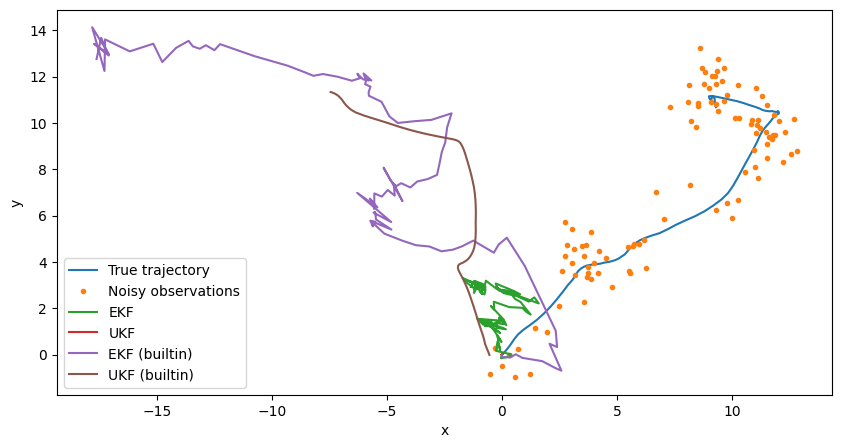

In [16]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(true_trajectory[:, 0], true_trajectory[:, 1], label="True trajectory")
plt.plot(noisy_observations[:, 0], noisy_observations[:, 1], '.', label="Noisy observations")
plt.plot(estimated_trajectory_EKF[:, 0], estimated_trajectory_EKF[:, 1], label="EKF")
plt.plot(estimated_trajectory_UKF[:, 0], estimated_trajectory_UKF[:, 1], label="UKF")
plt.plot(estimated_trajectory_EKF_builtin[:, 0], estimated_trajectory_EKF_builtin[:, 1], label="EKF (builtin)")
plt.plot(estimated_trajectory_UKF_builtin[:, 0], estimated_trajectory_UKF_builtin[:, 1], label="UKF (builtin)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.show()